<a href="https://colab.research.google.com/github/ahmedyasser7/DEPI_GP/blob/main/CASUALTY_SEVERITY_PREDICTIVE_MODEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CASUALTY SEVERITY PREDICTIVE MODEL**

# Uploading The Dataset

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving casualties cleaned data.csv to casualties cleaned data.csv


# Importing Libraries

In [ ]:
# Importing the necessary Libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import ADASYN
from collections import Counter
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


#Load the Dataset

In [ ]:
# Load the 'casualties cleaned data.csv' dataset
df = pd.read_csv('/content/casualties cleaned data.csv')

# Check the first few rows
df.head()

,Accident_Index,Casualty_Reference,Sex_of_Casualty,Age_of_Casualty,Casualty_Severity,Car_Passenger,Bus_or_Coach_Passenger,Casualty_Type
0,200901BS70001,1,1,77,2,0,0,2
1,200901BS70002,1,1,40,3,0,0,19
2,200901BS70002,2,1,38,3,0,0,11
3,200901BS70002,3,2,76,2,0,4,11
4,200901BS70002,4,1,42,2,0,4,11


# Exploring & Preprocessing the Data

In [ ]:
# Get information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1185983 entries, 0 to 1185982
Data columns (total 8 columns):
 #   Column                  Non-Null Count    Dtype 
---  ------                  --------------    ----- 
 0   Accident_Index          1185983 non-null  object
 1   Casualty_Reference      1185983 non-null  int64 
 2   Sex_of_Casualty         1185983 non-null  int64 
 3   Age_of_Casualty         1185983 non-null  int64 
 4   Casualty_Severity       1185983 non-null  int64 
 5   Car_Passenger           1185983 non-null  int64 
 6   Bus_or_Coach_Passenger  1185983 non-null  int64 
 7   Casualty_Type           1185983 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 72.4+ MB


In [ ]:
df.describe()

,Casualty_Reference,Sex_of_Casualty,Age_of_Casualty,Casualty_Severity,Car_Passenger,Bus_or_Coach_Passenger,Casualty_Type
count,1.185983e+06,1.185983e+06,1.185983e+06,1.185983e+06,1.185983e+06,1.185983e+06,1.185983e+06
mean,1.431425e+00,1.415368e+00,3.576307e+01,2.866305e+00,2.729634e-01,8.525839e-02,7.387409e+00
std,1.608286e+00,4.927855e-01,1.850742e+01,3.670351e-01,5.857770e-01,5.507572e-01,7.306746e+00
min,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,1.000000e+00,2.100000e+01,3.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00
50%,1.000000e+00,1.000000e+00,3.200000e+01,3.000000e+00,0.000000e+00,0.000000e+00,9.000000e+00
75%,2.000000e+00,2.000000e+00,4.800000e+01,3.000000e+00,0.000000e+00,0.000000e+00,9.000000e+00
max,8.520000e+02,2.000000e+00,1.030000e+02,3.000000e+00,2.000000e+00,4.000000e+00,9.800000e+01


In [ ]:
df.shape

(1185983, 8)

In [ ]:
# Check for missing values
df.isnull().sum()

,0
Accident_Index,0
Casualty_Reference,0
Sex_of_Casualty,0
Age_of_Casualty,0
Casualty_Severity,0
Car_Passenger,0
Bus_or_Coach_Passenger,0
Casualty_Type,0


In [ ]:
# Check for duplicate values
df.duplicated().sum()

0

# Model Selection & Training

## Define Features and Target Variable

In [ ]:
# Define feature columns and target variable
feature_columns = ['Sex_of_Casualty', 'Age_of_Casualty',
                   'Car_Passenger', 'Bus_or_Coach_Passenger', 'Casualty_Type']
X = df[feature_columns]
y = df['Casualty_Severity']


## Check Class Distribution

In [ ]:
# Check initial class distribution
print(f"Initial class distribution: {Counter(y)}")


Initial class distribution: Counter({3: 1038627, 2: 136152, 1: 11204})


## Split the Dataset

In [ ]:
# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Check class distribution after the split
print(f"Class distribution in training set: {Counter(y_train)}")
print(f"Class distribution in test set: {Counter(y_test)}")


Class distribution in training set: Counter({3: 830901, 2: 108922, 1: 8963})
Class distribution in test set: Counter({3: 207726, 2: 27230, 1: 2241})


## Handle Class Imbalance

In [ ]:
# Handle class imbalance using ADASYN on the training set
adasyn = ADASYN(sampling_strategy='minority', random_state=42)
X_balanced, y_balanced = adasyn.fit_resample(X_train, y_train)

# Display class distribution after ADASYN on training data
print(f"Class distribution after ADASYN on training set: {Counter(y_balanced)}")

# Handle class imbalance using ADASYN on the test set (for demonstration purposes)
X_test_balanced, y_test_balanced = adasyn.fit_resample(X_test, y_test)

# Display class distribution after ADASYN on test data
print(f"Class distribution after ADASYN on test set: {Counter(y_test_balanced)}")



Class distribution after ADASYN on training set: Counter({3: 830901, 1: 828271, 2: 108922})
Class distribution after ADASYN on test set: Counter({3: 207726, 1: 207498, 2: 27230})


## Create the Pipeline with KNN

In [ ]:
# Create a pipeline with scaling and the KNN model with fixed parameters
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scale features
    ('knn', KNeighborsClassifier(weights='distance', n_neighbors=3, metric='manhattan', leaf_size=40))  # KNN with specified parameters
])


## Train the Model

In [ ]:
# Train the model using the balanced training data
print("Training KNN model with specified parameters...")
pipeline.fit(X_balanced, y_balanced)


Training KNN model with specified parameters...


Pipeline(steps=[('scaler', StandardScaler()),
                ('knn',
                 KNeighborsClassifier(leaf_size=40, metric='manhattan',
                                      n_neighbors=3, weights='distance'))])

## Make Predictions and Evaluate

In [ ]:
# Make predictions on the original test set
y_pred_numeric = pipeline.predict(X_test)

# Define the mapping from numeric predictions to string labels
label_mapping = {1: 'Fatal', 2: 'Serious', 3: 'Slight'}

# Map the numeric predictions to string labels
y_pred_labels = [label_mapping[pred] for pred in y_pred_numeric]

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_numeric)

# Generate confusion matrix and classification report
conf_matrix = confusion_matrix(y_test, y_pred_numeric)
class_report = classification_report(y_test, y_pred_numeric)





## Store and Display Evaluation Results

In [ ]:
# Store evaluation results
evaluation_results = {
    'KNN': {
        'accuracy': accuracy,
        'confusion_matrix': conf_matrix,
        'classification_report': class_report
    }
}

# Display evaluation results for the KNN model
for model_name, results in evaluation_results.items():
    print(f"\nModel: {model_name}")
    print(f"Accuracy: {results['accuracy']:.4f}")




Model: KNN
Accuracy: 0.8372


## Visualize Confusion Matrix

KNN Classification Report:
              precision    recall  f1-score   support

           1       0.02      0.04      0.03      2241
           2       0.22      0.09      0.13     27230
           3       0.88      0.94      0.91    207726

    accuracy                           0.84    237197
   macro avg       0.37      0.36      0.36    237197
weighted avg       0.80      0.84      0.81    237197



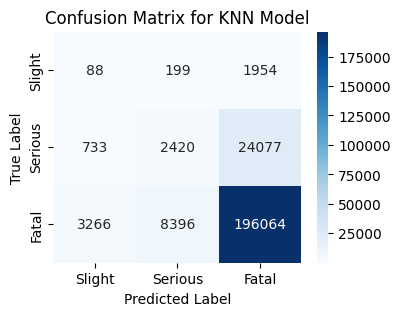

In [ ]:
# Print evaluation results
print(f"KNN Classification Report:\n{class_report}")

# Draw the confusion matrix using seaborn
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Slight', 'Serious', 'Fatal'],
            yticklabels=['Slight', 'Serious', 'Fatal'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for KNN Model')
plt.show()


# Save Model

In [ ]:
import pickle
model_filename = 'knn_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(pipeline, file)